In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
import glob
from pathlib import Path
import json
from shutil import copyfile
import itertools
from collections import Counter

# analytics
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Spacy Imports
import spacy

from spacy import displacy
from spacy.pipeline import EntityRuler
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token
from spacy.attrs import intify_attrs

def display_ent(doc):
    displacy.render(doc, style="ent", jupyter=True)

spacy_model = "en_core_web_lg"

nlp = spacy.load(spacy_model)

In [4]:
# User Source Code

import utilsCharlie

In [5]:
# Project Base
base_path = Path('..')

# Data Paths
data_path = base_path / 'data'
all_reports_path = data_path / 'wamex_xml'
subset_reports_path = data_path / 'subset'
test_reports_path = data_path / 'testset'

# Event Path
events_path = base_path / 'events'

# Dictionary Paths
dictionary_path = base_path / 'dictionary'
triggers_path = dictionary_path / 'triggers'
patterns_path = dictionary_path / 'patterns'

# NLP

## Load Match Pattern Pipelines

In [6]:
patterns = []
for filename in patterns_path.iterdir():
    with open(filename, encoding="utf8") as f:
        patterns += json.load(f)
        
print(f'loaded {len(patterns)} patterns')

loaded 31120 patterns


In [7]:
patterns[:5]

[{'label': 'ROCK',
  'pattern': [{'LOWER': 'acapulcoite'}, {'LOWER': 'meteorite'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'aceite'}]},
 {'label': 'ROCK',
  'pattern': [{'LOWER': 'acid'}, {'LOWER': 'volcanic'}, {'LOWER': 'rock'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'adakite'}]},
 {'label': 'ROCK', 'pattern': [{'LOWER': 'adamellite'}]}]

## Add patterns to nlp

In [8]:
ruler = EntityRuler(nlp, overwrite_ents=True)
ruler.add_patterns(patterns)

nlp.add_pipe(ruler)

## Load Trigger Words

In [9]:
trigger_words = []
for filename in triggers_path.iterdir():
    with open(filename, 'r') as f:
        trigger_words += [w.strip() for w in f.readlines()]
    
print(f'loaded {len(trigger_words)} trigger words\n')
print(trigger_words)

loaded 25 trigger words

['potential', 'drill', 'drilling', 'mineralisation', 'contain', 'promise', 'find', 'possible', 'enrich', 'enrichment', 'subeconomic', 'encouraging', 'extensive', 'patchy', 'minor', 'further drilling', 'low grade', 'medium grade', 'follow up', 'weak intercepts', 'minor intercepts', 'open at depth', 'along strike', 'exploration licence', 'prospective']


# Load Trigger Phrases/Words into Spacy PhraseMatcher


In [10]:
triggerPhrase = dictionary_path / 'trigger phrases'
near_miss_phrases =[]
for filename in triggerPhrase.iterdir():
    with open(filename, 'r') as f:
        for line in f:
            if len(line) > 1:
                near_miss_phrases.append(line[:-2].split())
f.close()

## Geology ent's to extract

In [11]:
geology_ents = ['ORE_DEPOSIT', 'ROCK', 'MINERAL', 'STRAT', 'LOCATION', 'TIMESCALE']

# Event Extraction

In [12]:
from utilsCharlie import create_event_df

eventdf = create_event_df(
    nlp=nlp, 
    directory=subset_reports_path, 
    trigger_phrases = near_miss_phrases, 
    geology_ents=geology_ents,
    n_sentences_extact=6,
)


extracting events on 100 files
found 701 events from a total of 8471 sentences


In [13]:
eventdf.head()

,event_id,filename,sentence_idx,sentence_text,n_trigger_words,trigger_words,event_text,ORE_DEPOSIT,ROCK,MINERAL,STRAT,LOCATION,TIMESCALE,event_label
0,a072171_2005 everlasting annual rpt_12941703_1,a072171_2005 everlasting annual rpt_12941703.json,1,a detailed report titled potential of the nors...,1,[potential],the norseman project has significant explorati...,[],[],[],[],"[norseman, norseman, norseman]",[],0
1,a072171_2005 everlasting annual rpt_12941703_3,a072171_2005 everlasting annual rpt_12941703.json,3,better definition of soil anomalies is require...,1,[mineralisation],a detailed report titled potential of the nors...,[],[],[],[],"[norseman, norseman]",[],0
2,a072171_2005 everlasting annual rpt_12941703_6,a072171_2005 everlasting annual rpt_12941703.json,6,exploration potential and recommendations.,1,[potential],regional geological setting . exploration comp...,[],[],[],[],[],[],0
3,a072171_2005 everlasting annual rpt_12941703_11,a072171_2005 everlasting annual rpt_12941703.json,11,croesus have recently developed and mined by o...,1,[mineralisation],the everlasting project covers an area of 436 ...,[],"[banded iron formation, bif]",[],"[penneshaw formation, noganyer formation]","[norseman, gladstone, gladstone, gladstone, gl...",[],0
4,a072171_2005 everlasting annual rpt_12941703_59,a072171_2005 everlasting annual rpt_12941703.json,59,the area around the gladstone and daisy teneme...,1,[mineralisation],archaean lithology the dominant archaean litho...,[],"[basalt, dolerite, gabbro, metasedimentary roc...","[gold, zircon]","[penneshaw formation, penneshaw formation]","[gladstone, gladstone, long]","[archaean, archaean, archaean]",0


## Save Events to csv file

In [14]:
## Make Sure you are saving to your allocated group number
event_path = events_path / 'group_6_events.csv'
eventdf.to_csv(event_path, index=False)

# Visualisations

## Frequency of number of trigger words found in each event

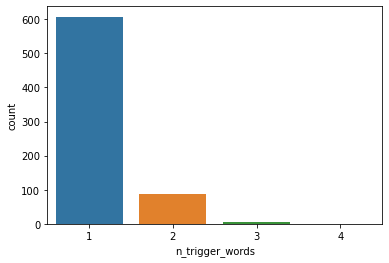

In [15]:
sns.countplot(eventdf.n_trigger_words);

## Count of each trigger word found

In [16]:
from utils import get_feature_counts_df

In [17]:
feature = 'trigger_words'
get_feature_counts_df(eventdf, feature)

,count
trigger_words,
mineralisation,326
potential,182
possible,85
extensive,69
broad,50
low grade,25
encouraging,18
favourable,14
enriched,11


In [18]:
feature = 'ORE_DEPOSIT'
get_feature_counts_df(eventdf, feature)

,count
ORE_DEPOSIT,
uranium,132
base metal,20
lode,17
iron ore,14
gold deposits,14
cid,13
pge,10
base metals,10
uranium deposits,10


In [19]:
feature = 'STRAT'
get_feature_counts_df(eventdf, feature)

,count
STRAT,
greenstone belt,28
fortescue group,12
coolbro sandstone,12
jeerinah formation,9
paterson formation,9
...,...
narracoota formation,1
silt dam monzogranite,1
deep river,1


In [20]:
feature = 'TIMESCALE'
get_feature_counts_df(eventdf, feature)

,count
TIMESCALE,
archaean,46
tertiary,24
proterozoic,22
eocene,10
permian,8
archean,7
mesoproterozoic,5
cainozoic,4
quaternary,4


In [21]:
feature = 'LOCATION'
get_feature_counts_df(eventdf, feature)

,count
LOCATION,
norseman,55
western australia,47
australia,31
gladstone,21
darlot,21
...,...
lake king,1
forrestania,1
gascoyne,1


# Ent Test

In [22]:
example = nlp(eventdf.iloc[0]['event_text'])
display_ent(example)

In [23]:
for ent in example.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

norseman 4 12 LOCATION
norseman 99 107 LOCATION
2002 116 120 DATE
norseman 174 182 LOCATION


In [24]:
minerals = [ent.text for ent in example.ents if ent.label_ == 'MINERAL']
minerals

[]